In [12]:
!pip install tiktoken

In [31]:
# Step 1: Import necessary modules from Langchain and other libraries

key = ""
from langchain.document_loaders import PyMuPDFLoader
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain

# Step 2: Load the PDF and Extract Text from the Report
pdf_path = "/content/Financial statment.pdf"  # Replace with your file path
pdf_loader = PyMuPDFLoader(pdf_path)
documents = pdf_loader.load()

# Preview the first 500 characters of the document to see the format
print("Preview of the first page content:")
print(documents[0].page_content[:500])

# Step 3: Create Embeddings and a Vector Store for Fast Querying
embeddings = OpenAIEmbeddings(openai_api_key = key)
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever()

# Step 4: Set up OpenAI's GPT Model (you can customize this model or use a different one)
llm = OpenAI(temperature=0, openai_api_key = key)

# Step 5: Create a Langchain Conversational Agent that will retrieve relevant information
agent = ConversationalRetrievalChain.from_llm(llm, retriever=retriever)

# Step 6: Define a Function to Query the Agent for Financial Data
import re


def get_financial_data(query):
    response = agent.run({"question": query, "chat_history": []})
    print(f"Response for query: {query}\n{response}\n")  # Debug print

    match = re.search(r"\$?[\d,]+\.\d+|\$?[\d,]+", response)

    if match:
        numeric_str = match.group(0).replace(",", "").replace("$", "")
        try:
            return float(numeric_str)
        except ValueError:
            raise ValueError(f"Could not convert extracted number to float: {numeric_str}")
    else:
        print(f"⚠️ No numeric value found for query: {query}")
        return None  # or float('nan') if you prefer


# Step 7: Extract Key Financial Data from the Report
# Make sure the queries match the format of the financial data in your report
def safe_get(query):
    value = get_financial_data(query)
    if value is None:
        print(f"⚠️ Warning: No numeric result for \"{query}\". Defaulting to 0.")
        return 0.0
    return value

# Step 7: Extract Key Financial Data
total_debt = safe_get("What is the total debt mentioned in the financial statement?")
total_equity = safe_get("What is the total equity mentioned in the financial statement?")
account_receivables = safe_get("What are the account receivables in the financial statement?")
inventories = safe_get("What is the inventory value mentioned in the financial statement?")
account_payables = safe_get("What are the account payables mentioned in the financial statement?")
current_assets = safe_get("What is the total value of current assets in USD?")
current_liabilities = safe_get("What is the total value of current liabilities in USD?")
total_assets = safe_get("What is the total value of assets in USD?")
# Step 8: Define a Function to Calculate Financial Ratios
def calculate_financial_ratios(debt, equity, receivables, inventories, payables, current_assets, current_liabilities, total_assets):
    # Debt to Equity Ratio
    debt_to_equity = debt / equity

    # Net Working Capital
    net_working_capital = receivables + inventories - payables

    # Equity Ratio
    equity_ratio = equity / total_assets

    # Current Ratio
    current_ratio = current_assets / current_liabilities

    return {
        "Debt to Equity Ratio": debt_to_equity,
        "Net Working Capital": net_working_capital,
        "Equity Ratio": equity_ratio,
        "Current Ratio": current_ratio
    }

# Step 9: Calculate the Ratios
ratios = calculate_financial_ratios(
    total_debt, total_equity, account_receivables, inventories, account_payables, current_assets, current_liabilities, total_assets
)

# Step 10: Display the Results
print("\nCalculated Financial Ratios:")
for ratio, value in ratios.items():
    print(f"{ratio}: {value:.2f}")




Preview of the first page content:
Apple Inc. 
CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited) 
(In millions, except number of shares, which are reflected in thousands, and per-share amounts) 
 
Three Months Ended 
 
December 30, 
2023 
 
December 31, 
2022 
Net sales: 
 
  
   Products 
! 
96,458   ! 
96,388  
   Services 
 
23,117    
20,766  
Total net sales (1) 
 
119,575    
117,154  
Cost of sales: 
 
  
   Products 
 
58,440    
60,765  
   Services 
 
6,280    
6,057  
Total cost of sales 
 
64,720    
66,822 
Response for query: What is the total debt mentioned in the financial statement?
 The total debt mentioned in the financial statement is $105,042 million. This includes both current and non-current liabilities, such as term debt and commercial paper.

Response for query: What is the total equity mentioned in the financial statement?
 The total equity mentioned in the financial statement is $74,100 million.

Response for query: What are the account receivables 

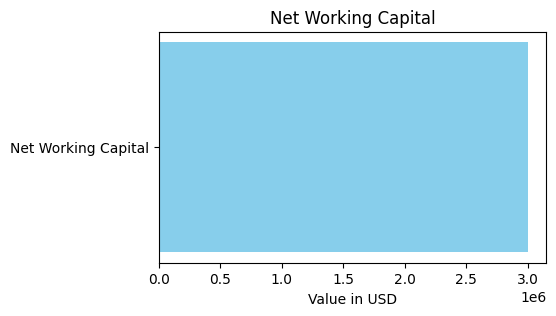

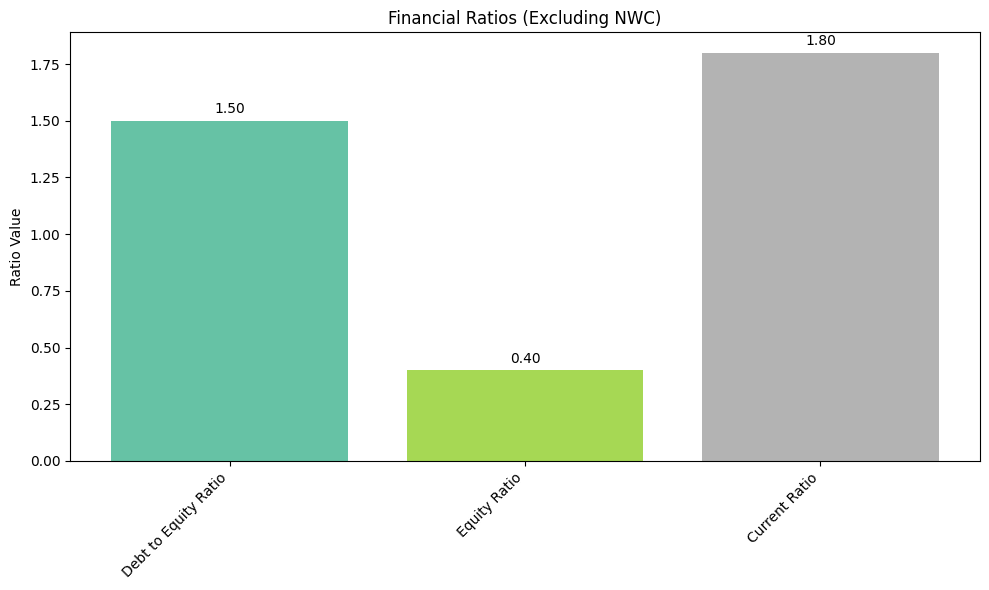

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'ratios' is defined somewhere above and contains the financial data
ratios = {
    "Debt to Equity Ratio": 1.5,
    "Net Working Capital": 3000000,  # Example NWC value
    "Equity Ratio": 0.4,
    "Current Ratio": 1.8
}

# Extract the NWC value from the ratios dictionary
nwc_value = ratios.get("Net Working Capital", None)  # Check if NWC exists

# Function to plot Net Working Capital (NWC)
def plot_net_working_capital(nwc_value):
    if nwc_value is None:
        print("No Net Working Capital data found.")
        return  # Exit if no NWC data is available

    plt.figure(figsize=(5, 3))  # Adjust size if necessary
    plt.barh(["Net Working Capital"], [nwc_value], color="skyblue")
    plt.xlabel('Value in USD')
    plt.title('Net Working Capital')
    plt.show()

# Function to plot the financial ratios with better styling
def plot_financial_ratios(ratios):
    # Remove Net Working Capital from the ratios dictionary for separate plotting
    if "Net Working Capital" in ratios:
        nwc_value = ratios.pop("Net Working Capital")  # Remove NWC for separate plotting
        plot_net_working_capital(nwc_value)  # Plot NWC first

    # Now plot the remaining financial ratios
    labels = list(ratios.keys())
    values = list(ratios.values())

    # Use a color palette for clarity
    color_map = plt.get_cmap("Set2")

    # Create a bar chart for financial ratios
    plt.figure(figsize=(10, 6))  # Adjust the size to fit the ratios chart
    bars = plt.bar(labels, values, color=color_map(np.linspace(0, 1, len(values))))

    # Add ratio values on top of the bars for clarity
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Ratio Value')
    plt.title('Financial Ratios (Excluding NWC)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Avoid overlap
    plt.show()

# Call the function to plot the financial ratios
plot_financial_ratios(ratios)
